# Snow events detection

This notebook contains tools to detect snowfalls and erosion of the snowpack.

The methods tested here are:
- least squares minimization between snow-depth curve and typical shape function (sum of step-exponentials)
- detection of points at which the snow-depth curve has a high standard deviation (large variations)

In [1]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt
from scipy import optimize
import math
import numpy as np
from datetime import datetime

### Importing basic functions

In [2]:
def median_spacetime_filtering(ds, min_periods_val, time_window=11, x_span=11, y_span=11):
    '''
    Function to apply median filtering in time and space
    Args:
        ds: clean data dataset
        time_window: time windo on which to apply median filter [index]
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    # ds['snow_surface'] = ds['mean'].rolling(time=time_window, min_periods=min_periods_val, center=True).median()
    # print(f'---> Median filtering in time with a window of {time_window}')
    ds['snow_surface'] = ds['mean'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()

In [3]:
def compute_time_derivatives(ds):
    '''
    Function to compute 1st and 2nd derivative of the snow surface height along the time axis
    Args:
        ds (xarray dataset): dataset containing snow surface data organized in ['time', 'y', 'x']
    Returns:
        A xarray dataset with the first and second order derivative
    '''
    grad1 = dask.array.gradient(ds['snow_surface'], axis=0, edge_order=1)
    grad2 = dask.array.gradient(grad1, axis=0, edge_order=1)

    gradients = ds.drop_vars(list(ds.keys()))
    gradients['first'] = (['time', 'y', 'x'], grad1)
    gradients['second'] = (['time', 'y', 'x'], grad2)
    print('---> Time derivatives computed')
    return gradients

In [4]:
def mean_time_filtering(ds, time_window=11):
    '''
    Function to apply mean filtering in time
    Args:
        ds: clean data dataset
        time_window: time window on which to apply mean filter [index]
    Returns:
    '''
    ds['snow_surface_smoothed'] = ds['snow_surface'].rolling(time=time_window, min_periods=7, center=True).mean()
    print(f'---> Mean filtering in time with a window of {time_window}')

In [5]:
def mean_area(ds):
    '''
    Function to compute the mean snow depth over an area
    Args:
        ds: clean data dataset
    Returns:
    '''
    # Faire un new dataset avec (time, mean depth) ? ou juste ajouter une entree dans ds ?
    ds['local_mean'] = ds['snow_surface'].mean()

### Defining data

In [6]:

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})

In [7]:

# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')

In [8]:
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = data_dec_jan_feb.ffill(dim='time')
median_spacetime_filtering(data_dec_jan_feb, 11)
data_dec_jan_feb['snow_surface'] = data_dec_jan_feb['snow_surface'] - data_dec_jan_feb['snow_surface'].min() 
# gradients_dec_jan_feb = compute_time_derivatives(data_dec_jan_feb)

# Defining coordinates
# Euh what are the referentials like? Quelle conversion faire ? (to get snowpit point)

x_sel = 11
y_sel = 11


---> Median filtering in space with a window [11, 11]


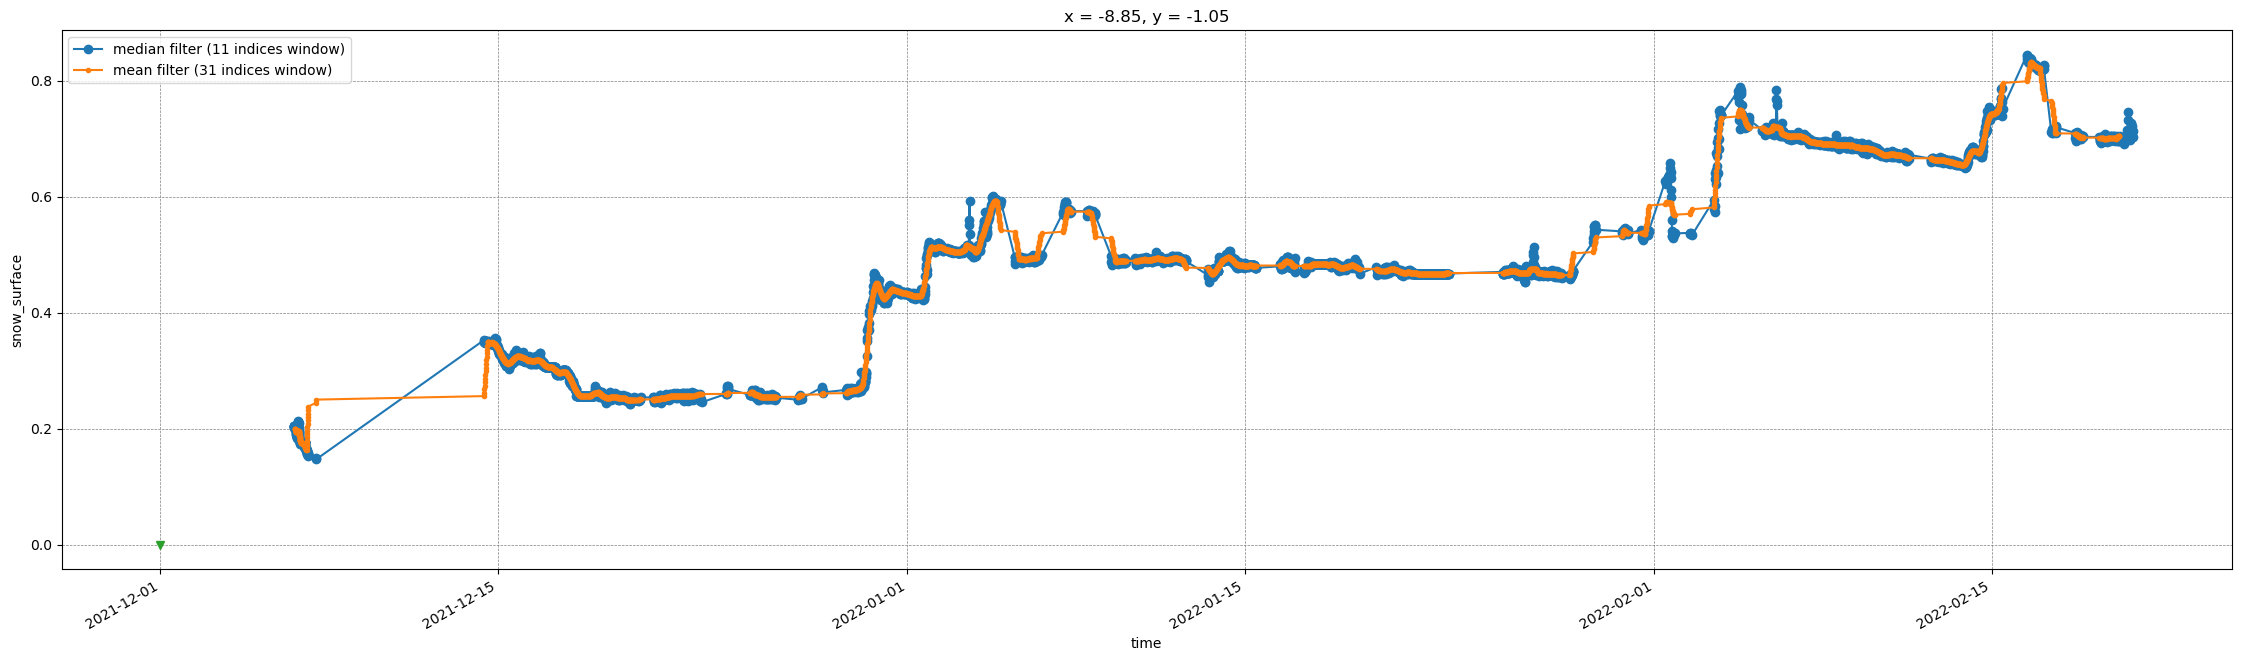

In [9]:

data_dec_jan_feb['snow_surface'].isel(x=x_sel, y=y_sel).plot(figsize=(28, 7), label='median filter (11 indices window)', marker='o')
data_dec_jan_feb['snow_surface'].isel(x=x_sel, y=y_sel).rolling(time=31, center=True).mean().plot(label='mean filter (31 indices window)', marker='.')
plt.plot(18962, 0, marker='v') # artificially add December 1st (empirical index) to be on the same scale as other met plots
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
#plt.savefig("snow_depth_data_dec_jan_feb.png")

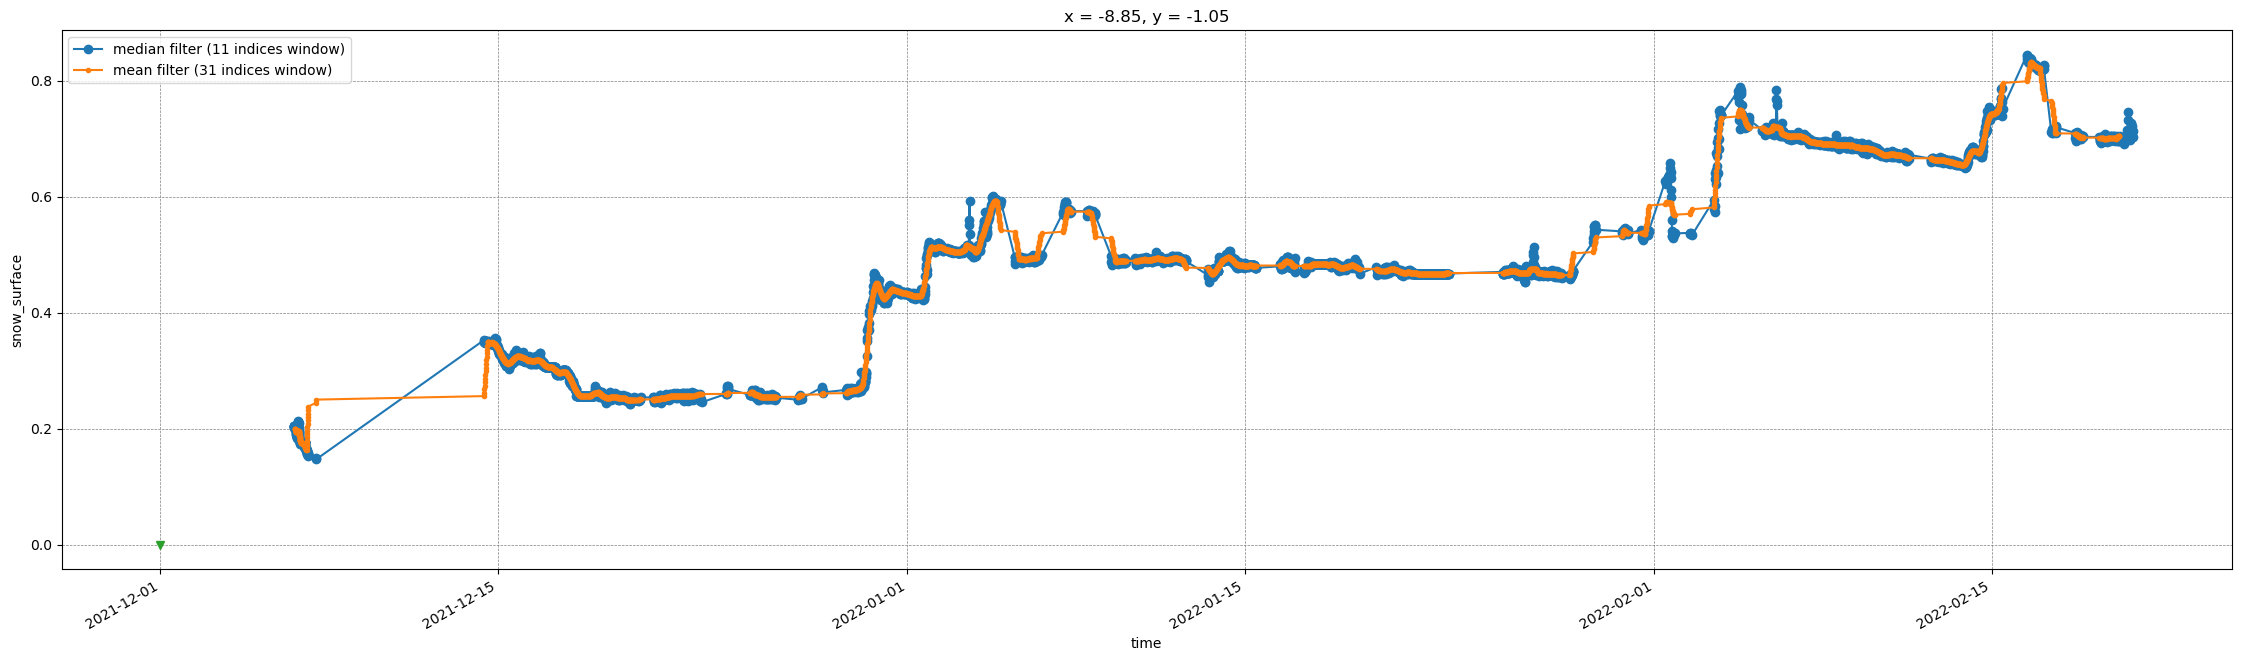

In [10]:

data_dec_jan_feb['snow_surface'].isel(x=x_sel, y=y_sel).plot(figsize=(28, 7), label='median filter (11 indices window)', marker='o')
data_dec_jan_feb['snow_surface'].isel(x=x_sel, y=y_sel).rolling(time=31, center=True).mean().plot(label='mean filter (31 indices window)', marker='.')
plt.plot(18962, 0, marker='v') # artificially add December 1st (empirical index) to be on the same scale as other met plots
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
#plt.savefig("snow_depth_data_dec_jan_feb.png")

### Computing shape function

The shape function corresponds to what we expect our data to look like. Here it is a combination of decreasing exponentials (to mimic the snowfalls and compaction general shape).

The objective is to use minimal square differences to compute the optimal parameters for this function to 'mimic' the shape of the data curve as well as possible. However, this requires quite a bit of knowledge, especially in terms of the snowfall dates, which is what we are trying to find out, so the solution is not adapted to our problem, and was set aside.

In [11]:
def indiv_exp(a, theta, tau, t_in_seconds):
    '''
    Function that computes the value at time t_in_seconds of a step function multiplied by a decreasing exponential (typical snowfall-compaction shape)
    Args:
        a: height of the step
        theta: time of the step
        tau: slope of the decrease
        t_in_seconds: time in seconds
    Returns:
        a * exp( -tau * (t_in_seconds - theta) )
    '''
    if t_in_seconds < theta:
        return(0)
    else:
        result = a * math.exp( -tau * (t_in_seconds-theta) )
        return(result)

In [12]:
def get_snow_depth(ds, index_t):
    '''
    Function that gives the lidar-measured snow height at point (11, 11)
    Args:
        ds: dataset containing snow height values (snow_surface)
        index_t: index of the time of interest in the dataset
    Returns:
        value of 'snow_surface' at that time
    '''
    result = float(ds['snow_surface'].isel(x=11, y=11, time=index_t))
    return(result)

In [13]:
def date_to_seconds(date_t):
    '''
    Function that converts a date to seconds
    Args:
        date_t: date in format eg. '1986-04-23T15:30' for April 23rd 1986, 3:30PM
    Returns:
        number of seconds since epoch at that date
    '''
    days = date_t.split('-')
    year, month = int(days[0]), int(days[1])
    timing = days[2].split('T')
    day = int(timing[0])
    hours = timing[1].split(':')
    hour, minute = int(hours[0]), int(hours[1])
    return((datetime(year, month, day, hour, minute).timestamp() - 1638792900.0) / 30000)

In [14]:
def shape_function(x):
    '''
    Function that combines 3 step-exponentials in one function
    Args:
        x: array containing (a1, tau1, theta1, a2, tau2, ...), parameters for each exponential computed
    Returns:
        sum of 3 step exponentials with given parameters
    '''
    shape_func = []
    timestamps_list = np.array(data_dec_jan_feb.isel(x=11, y=11).time)
    for index_t in range(len(timestamps_list)):
        shape_t = 0
        n = 3
        for i in range(n):
            time_in_seconds = date_to_seconds(str(timestamps_list[index_t]))
            shape_t += indiv_exp(x[3*i], x[3*i+1], x[3*i+2], time_in_seconds)
        shape_func.append(shape_t)
    return(shape_func)

In [15]:
def residual(x):
    '''
    Difference between the typical shape function to fit the snow-depth curve and the snow-depth curve
    Args:
        x: parameter array (a1, tau1, theta1, a2, tau2, ...)
    Returns:
        sum of 3 step-exponentials from which is substracted the snow depth curve
    '''
    resid = []
    timestamps_list = np.array(data_dec_jan_feb.isel(x=11, y=11).time)
    for index_t in range(len(timestamps_list)):
        shape_t = 0
        n = 3
        for i in range(n):
            time_in_seconds = date_to_seconds(str(timestamps_list[index_t]))
            shape_t += indiv_exp(x[3*i], x[3*i+1], x[3*i+2], time_in_seconds)
        resid.append(shape_t - get_snow_depth(data_dec_jan_feb, index_t))
    return(resid)

### Trying to fit function to curve manually

In [16]:
timestamps_list = np.array(data_dec_jan_feb.isel(x=11, y=11).time)

In [17]:
# plt.plot(timestamps_list, shape_function([1, 100, 0.001, 1, 37, 0.011, 37, 0.01, 1, 37, 0.01]))

In [18]:
# plt.plot(timestamps_list, residual([1, 100, 0.001, 1, 37, 0.01]))

In [19]:
# data_dec_jan_feb['snow_surface'].isel(x=x_sel, y=y_sel).plot(figsize=(28, 7), label='median filter (11 indices window)', marker='o')
# plt.plot(timestamps_list, shape_function([1, 100, 0.001, 1, 37, 0.01]))

### Datetime tools if needed (irrelevant here)

In [20]:
import pandas as pd
from datetime import datetime

In [21]:
a = pd.to_datetime('2021-07-01')
print(a)
a.timestamp()
# a.astype(int)
a

datetime(2021, 7, 1, 16, 30).timestamp() 

2021-07-01 00:00:00


1625149800.0

In [22]:
type(timestamps_list[1])

numpy.datetime64

In [23]:
a=pd.to_datetime(timestamps_list)

In [24]:
a.astype(int)

Int64Index([1638796500000000000, 1638796800000000000, 1638797100000000000,
            1638797400000000000, 1638797700000000000, 1638798000000000000,
            1638798300000000000, 1638798600000000000, 1638798900000000000,
            1638799200000000000,
            ...
            1645369200000000000, 1645371147000000000, 1645371900000000000,
            1645376400000000000, 1645379100000000000, 1645381800000000000,
            1645382700000000000, 1645385400000000000, 1645388100000000000,
            1645389000000000000],
           dtype='int64', length=4228)

### Regression

In [25]:
# Initial point
x_0 = [0.4, 10, 0.001, 0.2, 120, 0.01, 0.4, 18, 0.001]

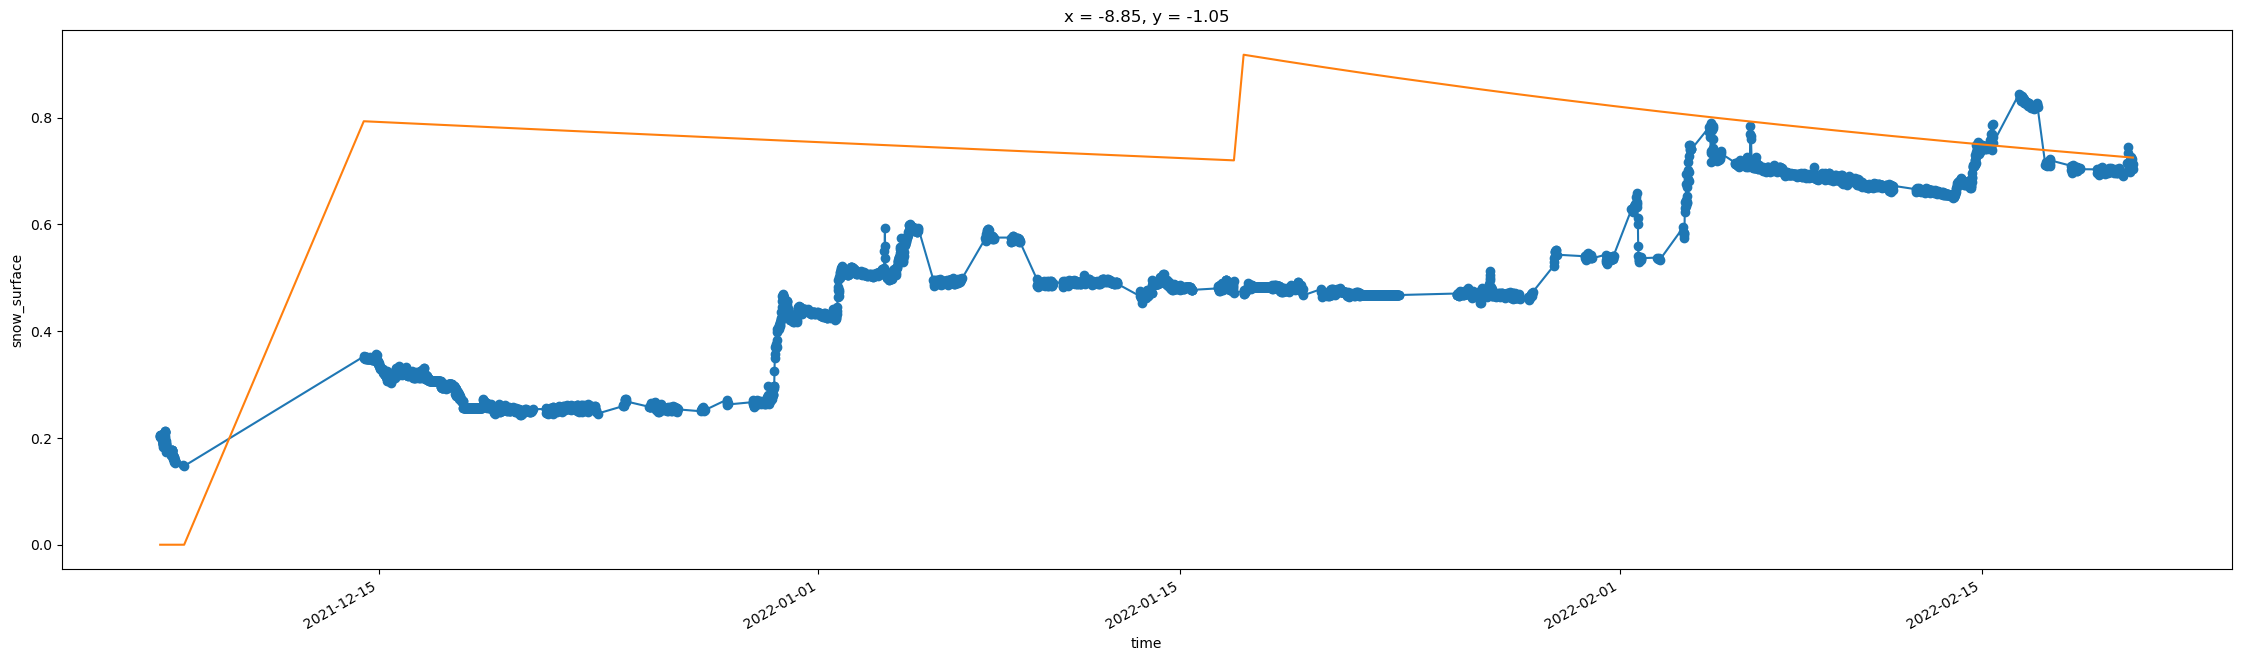

In [26]:
# Plot data

data_dec_jan_feb['snow_surface'].isel(x=x_sel, y=y_sel).plot(figsize=(28, 7), label='median filter (11 indices window)', marker='o')
plt.plot(timestamps_list, shape_function(x_0))


In [27]:
# Compute optimal parameters

# opt_param = optimize.least_squares(residual, x_0, bounds=((-60, 0, 0, -60, 0, 0, -60, 0, 0), (60, 600, 600, 60, 600, 600, 60, 600, 600)))
opt_param.x


NameError: name 'opt_param' is not defined

In [ ]:
# optimize.least_squares?

In [ ]:
# Plot result of 'optimal' parameters against snow depth data

data_dec_jan_feb[snow_surfaceurface'].isel(x=x_sel, y=y_sel).plot(figsize=(28, 7), label='median filter (11 indices window)', marker='o')
plt.plot(timestamps_list, shape_function(opt_param.x))
plt.plot(timestamps_list, shape_function(x_0), label='x_0')
plt.legend()


### Testing with taux accroissement local-ish (detection of points at which the standard deviation is high)

In [ ]:
# Plot rolling standard deviation against snow-depth curve

fig, ax = plt.subplots(2, 1, sharex=True)

data_dec_jan_feb.isel(x=11, y=11).snow_surface.rolling(time=50).std(dim='time').plot(ax=ax[0])
data_dec_jan_feb.isel(x=11, y=11).snow_surface.plot(ax=ax[1])

In [ ]:
# Plot rolling mean for two different rolling windows, rolling standard deviation and snow-depth curve

x_sel = 20
y_sel = 20

fig, ax = plt.subplots(3, 1, sharex=True)

data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=25, center=True).std(dim='time').plot(ax=ax[1])
data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=25, center=True).mean(dim='time').plot(ax=ax[0])
data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=25, center=False).mean(dim='time').plot(ax=ax[0])
data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.plot(ax=ax[2])


In [ ]:
# Convert rolling means and standard deviation to lists

stdev = data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=50, center=True).std(dim='time').values
mean_right_minus_mean_left = data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=25, center=True).mean(dim='time') - data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=25, center=False).mean(dim='time')
mean_right_minus_mean_left = mean_right_minus_mean_left.rolling(time=51, center=True).mean(dim='time').values


In [ ]:
# Plot difference between the two rolling means for different values of rolling window size

plt.plot(mean_right_minus_mean_left)
plt.plot(data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=51, center=True).mean(dim='time') - data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=50, center=False).mean(dim='time'))


In [ ]:
# Identify points at which standard deviation is high (beginning and end of peaks in stdev)

# plt.plot(stdev>0.025)
peaks = stdev>0.02
time_indexes = np.diff(peaks.astype(int))
# plt.plot(time_indexes)
indexes = np.where(time_indexes==1)
end_indexes = np.where(time_indexes==-1)
indexes

In [ ]:
# mean_right_minus_mean_left[129]

In [ ]:
# Plot snow-depth curve with points at which snow events start and end
# Depending on the sign of the rolling means' difference, the events are identified as snowfalls or erosions

rise = []
fall = []
end_rise = []
end_fall = []
for index in range(len(indexes[0])):
    if mean_right_minus_mean_left[indexes[0][index]+20] >= 0:   # take 20 indices later to account for lag due to window size
        rise.append(indexes[0][index])
        end_rise.append(end_indexes[0][index])
    else:
        fall.append(indexes[0][index])
        end_fall.append(end_indexes[0][index])
        
print(rise, fall, end_rise, end_fall)

plt.figure(figsize=(18, 10))
data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2)
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=rise).snow_surface.plot(marker='^', markersize=13, linestyle='None')
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=fall).snow_surface.plot(marker='v', markersize=13, linestyle='None')
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=end_rise).snow_surface.plot(marker='^', markersize=13, linestyle='None')
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=end_fall).snow_surface.plot(marker='v', markersize=13, linestyle='None', c='r')
